In [1]:
using PyPlot
using Revise
using MDToolbox
using StatsBase # for calculating histogram
using Printf
using Plots
using DelimitedFiles
using JSON
PyPlot.plt[:style][:use]("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[1]:9
└ @ Core In[1]:9
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[1]:9
└ @ Core In[1]:9


In [2]:
# setup constants
KBT = KB_kcalpermol*300.0
BIN_NUMBER = 181; # number of bins
HIST_EDGE = range(-1, stop=181, length=BIN_NUMBER+1)
BIN_CENTER = 0.5 .* (HIST_EDGE[2:end] .+ HIST_EDGE[1:(end-1)])
SETTING_FILE_NAME = "setting_file.txt"
SPRING_CONSTANT = 200.0 * (pi/180.0)^2; # conversion of the unit from kcal/mol/rad^2 to kcal/mol/deg^2

In [3]:
# read setting data
setting_data = Dict()

open(SETTING_FILE_NAME, "r") do f
    global setting_data
    dict_txt = read(f, String)  # file information to string
    setting_data=JSON.parse(dict_txt)  # parse and transform data
end

Dict{String,Any} with 3 entries:
  "outputFiles" => Dict{String,Any}("1"=>Any["simulation/data/run_1.dat"],"54"=>Any["simulation/data/run_42.d…
  "tryCount"    => 100
  "nextSearch"  => 59

In [4]:
# read dihedral angle data
simulation_data = []
umbrella_centers = []
data_size = 0
for angle in 0:180
    file_names = setting_data["outputFiles"]["$angle"]
    for file_name in file_names
        data_size += 1
        x = readdlm(file_name)
        push!(simulation_data, x[:, 2])
        push!(umbrella_centers, angle)
    end
end

In [5]:
# calculate histogram (h_km)
# h_km: histogram (data counts) of k-th umbrella data counts in m-th data bin
histogram_matrix = zeros(Int64, data_size, BIN_NUMBER)
for i in 1:data_size
  hist = fit(Histogram, simulation_data[i], HIST_EDGE)
  histogram_matrix[i, :] = hist.weights
end

histogram_matrix

100×181 Array{Int64,2}:
 13  20  10  11  8   1   0   0   0   0   0  0  0   0  …   0   0   0   0   0   0   0   0  0   0   0   0   0
 21  14  14   9  5   1   0   0   0   0   0  0  0   0      0   0   0   0   0   0   0   0  0   0   0   0   0
 19  14   9   7  6   1   6   1   0   0   0  0  0   0      0   0   0   0   0   0   0   0  0   0   0   0   0
 12  18  18  20  8   4   3   1   0   0   0  0  0   0      0   0   0   0   0   0   0   0  0   0   0   0   0
  0   0   0   2  7  11  10  19  17  13  11  7  2   1      0   0   0   0   0   0   0   0  0   0   0   0   0
  0   0   1   3  2   8   5  18  20  19  15  6  1   2  …   0   0   0   0   0   0   0   0  0   0   0   0   0
  0   1   2   0  4   6  13  17  21  17   7  6  2   2      0   0   0   0   0   0   0   0  0   0   0   0   0
  0   0   0   1  3   8   9  12  25  12  14  7  5   3      0   0   0   0   0   0   0   0  0   0   0   0   0
  0   0   0   0  0   0   0   0   0   0   0  4  6   8      0   0   0   0   0   0   0   0  0   0   0   0   0
  0   0   0  

In [6]:
# bias-energy
# bias_km: bias-factor of k-th umbrella-window evaluated at m-th bin-center
function minimum_image(center, x)
  dx = x .- center
  dx = dx .- round.(dx./360.0).*360.0;
  return dx
end

bias_matrix = zeros(Float64, data_size, BIN_NUMBER)
for i in 1:data_size
  for j in 1:BIN_NUMBER
    bias_matrix[i, j] = (SPRING_CONSTANT./KBT) * (minimum_image(Float64(umbrella_centers[i]), BIN_CENTER[j])).^2
  end
end

In [7]:
# solve WHAM equations, and
# calculate probabilities in the dihedral angle space, and evaluate the potential of mean force (PMF)
f_k, pmf = wham(histogram_matrix, bias_matrix)
pmf = KBT .* pmf;
pmf = pmf .- pmf[1]

1×181 Array{Float64,2}:
 0.0  0.014067  0.0658614  -0.0756286  -0.0691517  …  -5.73464  -5.76025  -5.89117  -5.77047  -5.85418

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:2
└ @ Core In[8]:2
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:5
└ @ Core In[8]:5
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:8
└ @ Core In[8]:8
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:8
└ @ Core In[8]:8
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot over

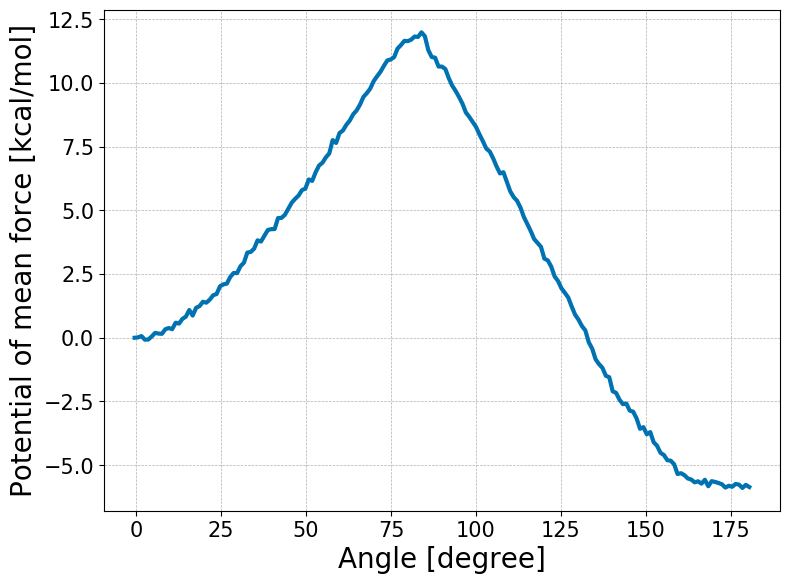

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:10
└ @ Core In[8]:10


In [8]:
fig, ax = subplots(figsize=(8, 6))
ax[:plot](BIN_CENTER, pmf[:], linewidth=3)
xlabel("Angle [degree]",fontsize=20)
ylabel("Potential of mean force [kcal/mol]",fontsize=20)

# detailed options (not necessary, just for reference)
ax[:grid](linestyle="--", linewidth=0.5)
ax[:xaxis][:set_tick_params](which="major",labelsize=15)
ax[:yaxis][:set_tick_params](which="major",labelsize=15)
ax[:grid](linestyle="--", linewidth=0.5)
tight_layout()

In [9]:
window = 0
for i in 1:length(pmf)
    println(window, " ", pmf[i],)
    window += 1
end

0 0.0
1 0.014067036577669808
2 0.06586136312667702
3 -0.07562862784700265
4 -0.06915169278206851
5 0.04974899554546807
6 0.19038123666978476
7 0.1634120441237279
8 0.15480741375414075
9 0.3346692560874093
10 0.38089985197670273
11 0.33558261204584106
12 0.5902913537493846
13 0.5552612406468475
14 0.7411778839891756
15 0.827887464271364
16 1.0866897324948277
17 0.8697576339362664
18 1.174111430776664
19 1.2397155036328615
20 1.4113462470269522
21 1.376167335152944
22 1.4940719369888988
23 1.6676848172106062
24 1.7145169966797693
25 2.018867634650268
26 2.094446033385426
27 2.120974009129472
28 2.38462342275357
29 2.5413117395696125
30 2.5359089436829216
31 2.8054842332361245
32 2.943412232539456
33 3.339946268931268
34 3.366513668037754
35 3.4948091520466313
36 3.820463002098423
37 3.773648887699986
38 4.001313741687516
39 4.224806796688059
40 4.2598001667591685
41 4.261829632274818
42 4.6948767371288875
43 4.701054849819904
44 4.8219260820486
45 5.061716026208451
46 5.296842305276909
4